In [130]:
import cobra
from cobra.flux_analysis import single_gene_deletion, flux_variability_analysis
import pandas as pd
import cplex

**1. Dans cobrapy, Créer le modèle à partir du réseau SBML téléchargé précédemment**

In [131]:
model = cobra.io.read_sbml_model("ralsto_metexplore3.xml")
model


Adding exchange reaction EX_hdcea_b with default bounds for boundary metabolite: hdcea_b.
Adding exchange reaction EX_RSc1944_b with default bounds for boundary metabolite: RSc1944_b.
Adding exchange reaction EX_3oochslac_b with default bounds for boundary metabolite: 3oochslac_b.
Adding exchange reaction EX_glu_D_b with default bounds for boundary metabolite: glu_D_b.
Adding exchange reaction EX_RipS4_b with default bounds for boundary metabolite: RipS4_b.
Adding exchange reaction EX_fecrm_b with default bounds for boundary metabolite: fecrm_b.
Adding exchange reaction EX_ni2_b with default bounds for boundary metabolite: ni2_b.
Adding exchange reaction EX_RipK_b with default bounds for boundary metabolite: RipK_b.
Adding exchange reaction EX_berb_b with default bounds for boundary metabolite: berb_b.
Adding exchange reaction EX_tartr_L_b with default bounds for boundary metabolite: tartr_L_b.
Adding exchange reaction EX_octa_b with default bounds for boundary metabolite: octa_b.
Addi

Name,_bc9d1403_3bf5_4994_8369_f3c28ce8995a
Memory address,7f532345da90
Number of metabolites,2574
Number of reactions,3097
Number of genes,2219
Number of groups,253
Objective expression,0
Compartments,"boundary, extracellular, cytoplasm, periplasm"


**2. Combien de réactions, métabolites, gènes contient le réseau ?**

In [132]:
n_reactions = len(model.reactions)
n_metabolites = len(model.metabolites)
n_genes = len(model.genes)
print("le nombre de reaction : ", n_reactions)
print("le nombre de metabolites : ", n_metabolites) 
print("le nombre de genes : ", n_genes)


le nombre de reaction :  3097
le nombre de metabolites :  2574
le nombre de genes :  2219


**3. Indiquer la réaction BIOMASS comme fonction objectif**

In [133]:
for x in model.reactions:
    if "biomass" in x.id.lower():
        print(x.id)

BIOMASS


In [134]:
model.objective = "BIOMASS"
print("Objectif fixé à :", model.objective)


Objectif fixé à : Maximize
1.0*BIOMASS - 1.0*BIOMASS_reverse_69053


**4. Mettre à 0 la “lower bound” de toutes réactions d’échange du modèle.**

In [135]:
for rx in model.exchanges:
    rx.lower_bound = 0.0

In [136]:
# je verifie pour voir
[(rx.id, rx.lower_bound, rx.upper_bound) for rx in list(model.exchanges)[:10]]


[('EX_hdcea_b', 0.0, 1000.0),
 ('EX_RSc1944_b', 0.0, 1000.0),
 ('EX_3oochslac_b', 0.0, 1000.0),
 ('EX_glu_D_b', 0.0, 1000.0),
 ('EX_RipS4_b', 0.0, 1000.0),
 ('EX_fecrm_b', 0.0, 1000.0),
 ('EX_ni2_b', 0.0, 1000.0),
 ('EX_RipK_b', 0.0, 1000.0),
 ('EX_berb_b', 0.0, 1000.0),
 ('EX_tartr_L_b', 0.0, 1000.0)]

**5. Fixer les “lower bound” et “upper bound” des réactions d’échange faisant intervenir les métabolites ci-dessous respectivement à -1000 et à 1000: h2o_b, h_b, k_b, pi_b, na1_b, nh4_b, so4_b, mg2_b, cl_b, fe2_b, fe3_b, cobalt2_b, mn2_b, mobd_b, o2_b, co2_b.**
(Indice : les réactions commencent par EX_nomdumetabolite)

In [137]:
met_list = ["h2o_b","h_b","k_b","pi_b","na1_b","nh4_b","so4_b","mg2_b",
            "cl_b","fe2_b","fe3_b","cobalt2_b","mn2_b","mobd_b","o2_b","co2_b"]

trouvee = {}

for met in met_list:
    target = "EX_" + met
    match = [rx for rx in model.exchanges if rx.id == target]

    if len(match) == 1:
        rx = match[0]
        rx.lower_bound = -1000.0
        rx.upper_bound = 1000.0
        trouvee[met] = rx.id
    else:
        print(f"Aucune réaction d’échange EXACTE trouvée pour {met}")

print("Échanges modifiés :", trouvee) # j'ai fait pour verifier que j'ai toute la liste


Échanges modifiés : {'h2o_b': 'EX_h2o_b', 'h_b': 'EX_h_b', 'k_b': 'EX_k_b', 'pi_b': 'EX_pi_b', 'na1_b': 'EX_na1_b', 'nh4_b': 'EX_nh4_b', 'so4_b': 'EX_so4_b', 'mg2_b': 'EX_mg2_b', 'cl_b': 'EX_cl_b', 'fe2_b': 'EX_fe2_b', 'fe3_b': 'EX_fe3_b', 'cobalt2_b': 'EX_cobalt2_b', 'mn2_b': 'EX_mn2_b', 'mobd_b': 'EX_mobd_b', 'o2_b': 'EX_o2_b', 'co2_b': 'EX_co2_b'}


**6. Question : Pourquoi met-on le flux lower bound à 0 pour toutes les réactions d’échange
sauf pour les réactions faisant intervenir certains métabolites ?**

On met la borne inférieure à 0 pour la plupart des réactions d’échange afin d’empêcher l’import non controlé depuis l’environnement. Comme ça, on contrôle quelles sources externes sont réellement disponibles expérimentalement.
On autorise l’importation (borne négative) seulement pour certains métabolites effectivement présents dans le milieu (ions inorganiques, O₂, CO₂, eau…), ce qui évite des importations irréalistes.

**7. Fixer les flux des réactions suivantes aux valeurs suivantes :
NGAME : 8.39 (réaction correspondant à un flux de consommation d’ATP correspondant
à une maintenance de la cellule)
FEOXpp : 0 (cette réaction quand elle est active peut amener à produire de l’ATP
“gratuitement”)**

In [138]:
print("Matches NGAME:", [r.id for r in model.reactions if 'ngame' in r.id.lower()])
print("Matches FEOXpp:", [r.id for r in model.reactions if 'feox' in r.id.lower()])

Matches NGAME: ['NGAME']
Matches FEOXpp: ['FEOXpp']


In [139]:
model.reactions.get_by_id("NGAME").lower_bound = 8.39
model.reactions.get_by_id("NGAME").upper_bound = 8.39

model.reactions.get_by_id("FEOXpp").lower_bound = 0.0
model.reactions.get_by_id("FEOXpp").upper_bound = 0.0

**8. Calculer le taux de croissance dans ces conditions.**  
**Quels sont les métabolites importés qui permettent ce taux de croissance optimal ?**  
**Quels sont les métabolites excrétés ?**

In [140]:
model.solver = 'glpk'
sol = model.optimize()
print("taux de croissance (objective) =", sol.objective_value)


taux de croissance (objective) = 0.0


/home/kerima/.cobraenv/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [141]:
ex_fluxes = [(rx.id, float(sol.fluxes[rx.id])) for rx in model.exchanges if abs(float(sol.fluxes[rx.id])) > 1e-9]
df = pd.DataFrame(ex_fluxes, columns=["exchange", "flux"]).sort_values("flux")

imports = df[df["flux"] < 0]
exports = df[df["flux"] > 0]

print("les metabolites importés :")
display(imports)

print("les metabolites exportés :")
display(exports)


les metabolites importés :


,exchange,flux
1,EX_o2_b,-2.002918
4,EX_h2o_b,-1.068223
2,EX_h_b,-0.801167


les metabolites exportés :


,exchange,flux
5,EX_pi_b,0.801167
0,EX_nh4_b,1.335279
3,EX_co2_b,2.670557


**9. Fixer le flux lower bound et upper des réactions de transports des métabolites
ci-dessous, aux valeurs données ci-dessous :
glu_L_b : -8.25
3ohpame_b : 1.5E-4
EPS_b : 0.0062
ptrc_b : 0.28
Tek_28kd_b : 2.7E-4
etle_b : 0.0129**  
**Quel est le taux de croissance dans ces conditions ?**

In [142]:
mapping = {
    "EX_glu_L_b": -8.25,
    "EX_3ohpame_b": 1.5E-4,
    "EX_EPS_b": 0.0062,
    "EX_ptrc_b": 0.28,
    "EX_Tek_28kd_b": 2.7E-4,
    "EX_etle_b": 0.0129
}

for rx_id, val in mapping.items():
    rx = model.reactions.get_by_id(rx_id)
    rx.lower_bound = val
    rx.upper_bound = val
    print("Fixé", rx.id, "=", val)

sol_exp = model.optimize()
print("taux de croissance sous conditions expérimentales:", sol_exp.objective_value)

Fixé EX_glu_L_b = -8.25
Fixé EX_3ohpame_b = 0.00015
Fixé EX_EPS_b = 0.0062
Fixé EX_ptrc_b = 0.28
Fixé EX_Tek_28kd_b = 0.00027
Fixé EX_etle_b = 0.0129
taux de croissance sous conditions expérimentales: 0.5119279935093651


**Que pouvez-vous en dire ?**  

Dans le premier cas, seules les réactions NGAME (consommation minimale d’ATP pour la maintenance) et FEOXpp (production d’ATP désactivée) sont fixées, sans apport de nutriments carbonés. Le modèle prédit un taux de croissance nul, car la cellule ne dispose pas des sources de carbone et des précurseurs nécessaires pour produire de la biomasse, malgré la consommation d’ATP et les échanges d’ions inorganiques pour la maintenance. Dans le deuxième cas, les flux des réactions de transport des principaux nutriments expérimentaux (glucose, acides aminés, EPS, etc.) sont fixés aux valeurs mesurées. Cela permet au modèle de simuler l’apport en carbone et précurseurs indispensables à la biosynthèse, ce qui conduit à une croissance positive (taux de croissance = 0,512). Ainsi, la comparaison des deux cas montre que la disponibilité des nutriments externes est déterminante pour permettre la croissance cellulaire dans le modèle, alors que l’ATP seul ne suffit que pour la maintenance.

**10. Expérimentalement, Ralstonia solanacearum pousse à 0.28h-1. Calculer la valeur du flux
de la réaction NGAME pour atteindre ce taux de croissance en FBA. Quelle est cette
valeur ? Trouver la méthode la plus parcimonieuse pour trouver cette valeur et décrire
la.**

In [143]:
m = model.copy() 

In [144]:
m.reactions.BIOMASS.lower_bound = 0.28
m.reactions.BIOMASS.upper_bound = 0.28

In [145]:
m.objective = "NGAME"
m.objective_direction = "min"

In [146]:
sol = m.optimize()
flux_NGAME = sol.fluxes["NGAME"]
print("Flux minimal de NGAME pour atteidre 0.28 h⁻¹ :", flux_NGAME)

Flux minimal de NGAME pour atteidre 0.28 h⁻¹ : 8.39


Ce résultat est parcimonieux : il correspond au flux minimal de NGAME nécessaire pour atteindre le taux de croissance fixé. Cette approche est dite parcimonieuse car elle identifie le flux strictement nécessaire pour atteindre l’objectif, sans excès ni arbitrage des autres flux. Ainsi, plutôt que de tester différentes valeurs ou de laisser les flux libres, une seule optimisation permet de déterminer directement la valeur minimale obligatoire de NGAME pour obtenir la croissance souhaitée.

**11. Sauver les valeurs de flux dans un fichier tabulé (attention, pensez à ajouter les suffixes
R_ ! ) et les mapper sur les arêtes du sous-réseau métabolique du dessin de la
glycolyse de Ralstonia dans MetExplore 3 (dans l’outil de visualisation : mappings -> flux
visualisation) . Arranger le dessin en dupliquant/retirant les composés ubiquitaires (H2O,
ATP, etc…). Sauvegarder l’image dans le notebook.**

In [147]:
sol = model.optimize()
fluxes = sol.fluxes.reset_index()
fluxes.columns = ["reaction","flux"]

fluxes["map_id"] = fluxes["reaction"].apply(lambda x: "R_" + x)

fluxes_out = fluxes[["map_id", "flux"]]
fluxes_out.to_csv("fluxes_for_metexplore.csv", sep="\t", index=False)

print("Fichier écrit : fluxes_for_metexplore.csv")


Fichier écrit : fluxes_for_metexplore.csv


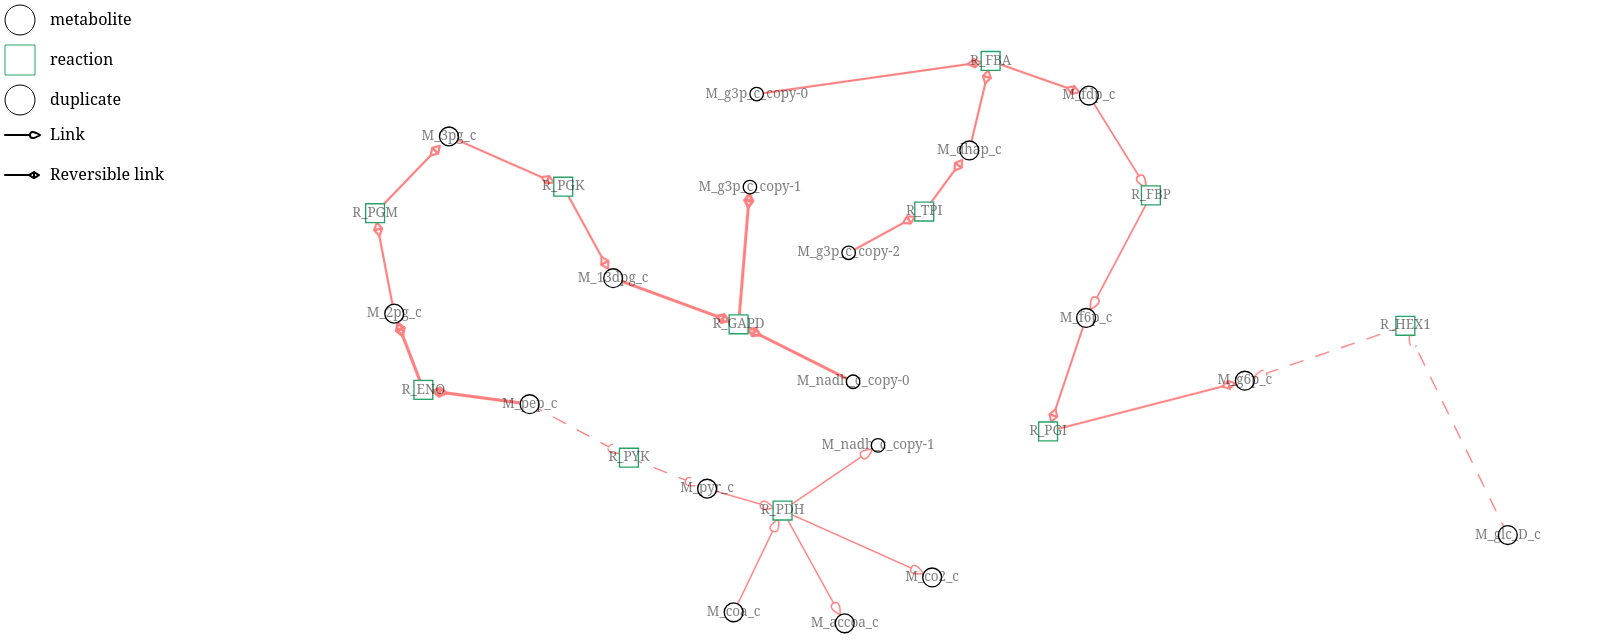

**12. Déterminer avec cobrapy les gènes essentiels qui permettent cette croissance optimale.
Les mapper sur MetExplore 3. Quelles sont les voies métaboliques contenant ces gènes
métaboliques ? Les lister dans le notebook et y copier l’image du résultat du mapping
montrant les voies métaboliques contenant les gènes.**

In [160]:
from cobra.flux_analysis import single_gene_deletion

base_sol = model.optimize()
base_growth = float(base_sol.objective_value)
print("Croissance de référence :", base_growth)

result = single_gene_deletion(model)  
essential = result[result['growth']<1e-9]
essential_genes = essential["ids"].tolist()
print("Nombre de gènes essentiels:", len(essential_genes))
essential_genes[:50]


Croissance de référence : 0.5119279935093644
Nombre de gènes essentiels: 195


[{'RSc2449'},
 {'RSc1409'},
 {'RSc2416'},
 {'RSc2461'},
 {'RSc2953'},
 {'RSc2843'},
 {'RSc2222'},
 {'d0094'},
 {'RSc2387'},
 {'RSc1979'},
 {'d0055'},
 {'RSc1021'},
 {'RSc1984'},
 {'d0080'},
 {'RSp0623'},
 {'e0093'},
 {'RSc2643'},
 {'RSp0624'},
 {'RSc2532'},
 {'RSc0109'},
 {'RSp0106'},
 {'RSc2202'},
 {'RSc1127'},
 {'RSc1414'},
 {'RSc0575'},
 {'RSc0372'},
 {'RSc2731'},
 {'e0265'},
 {'RSp0621'},
 {'RSc3303'},
 {'RSc0687'},
 {'RSc0913'},
 {'RSc2881'},
 {'RSc0574'},
 {'RSc0413'},
 {'e0197'},
 {'RSc2397'},
 {'RSc2204'},
 {'RSp0242'},
 {'RSc0898'},
 {'RSc1020'},
 {'RSc1379'},
 {'RSc0693'},
 {'RSc2977'},
 {'RSc2200'},
 {'RSc0311'},
 {'RSp0239'},
 {'RSc2844'},
 {'RSc0678'},
 {'RSc0139'}]

In [166]:
essential_gene_ids = [list(g)[0] for g in essential_genes]
essential_gene_ids[:10]

['RSc2449',
 'RSc1409',
 'RSc2416',
 'RSc2461',
 'RSc2953',
 'RSc2843',
 'RSc2222',
 'd0094',
 'RSc2387',
 'RSc1979']

In [165]:
df = pd.DataFrame({"gene": essential_gene_ids})

df.to_csv("essential_genes.csv", index=False)

df.head()

,gene
0,RSc2449
1,RSc1409
2,RSc2416
3,RSc2461
4,RSc2953


In [ ]:
voies = pd.read_csv("liste_voies.csv")
voies

,Id,Name,Size (nb of reactions),mes_genes,Nb of genes mapped (mes_genes),Percentage of genes mapped (mes_genes),P-value (mes_genes),Bonferroni p-value (mes_genes),Benjamini-Hochsberg p-value (mes_genes),Actions
0,Glycine_and_serine_degradation,Glycine_and_serine_degradation,4,True,1,12.50%,5.215000e-01,1.000000e+00,6.151000e-01,NaN
1,Putrescine_degradation,Putrescine_degradation,6,True,1,20.00%,3.689000e-01,1.000000e+00,4.714000e-01,NaN
2,Pyridoxal_5__phosphate_biosynthesis,Pyridoxal_5__phosphate_biosynthesis,7,True,3,37.50%,2.690000e-02,1.000000e+00,5.620000e-02,NaN
3,Purine_biosynthesis,Purine_biosynthesis,30,True,9,34.62%,2.000000e-04,1.000000e-02,8.000000e-04,NaN
4,Fatty_acid_biosynthesis,Fatty_acid_biosynthesis,60,True,2,9.09%,5.889000e-01,1.000000e+00,6.772000e-01,NaN
5,Thiamin_biosynthesis,Thiamin_biosynthesis,10,True,5,41.67%,2.400000e-03,1.087000e-01,6.400000e-03,NaN
6,Flavin_biosynthesis,Flavin_biosynthesis,9,True,5,71.43%,9.051700e-05,4.200000e-03,4.000000e-04,NaN
7,Transport_ion_substrate,Transport_ion_substrate,103,True,11,11.11%,2.483000e-01,1.000000e+00,3.569000e-01,NaN
8,IAA_biosynthesis,IAA_biosynthesis,4,True,1,16.67%,4.245000e-01,1.000000e+00,5.278000e-01,NaN
9,Coenzyme_A_biosynthesis,Coenzyme_A_biosynthesis,9,True,6,60.00%,6.651100e-05,3.100000e-03,3.000000e-04,NaN


**L’image du résultat du mapping
montrant les voies métaboliques contenant les gènes esssentiels**

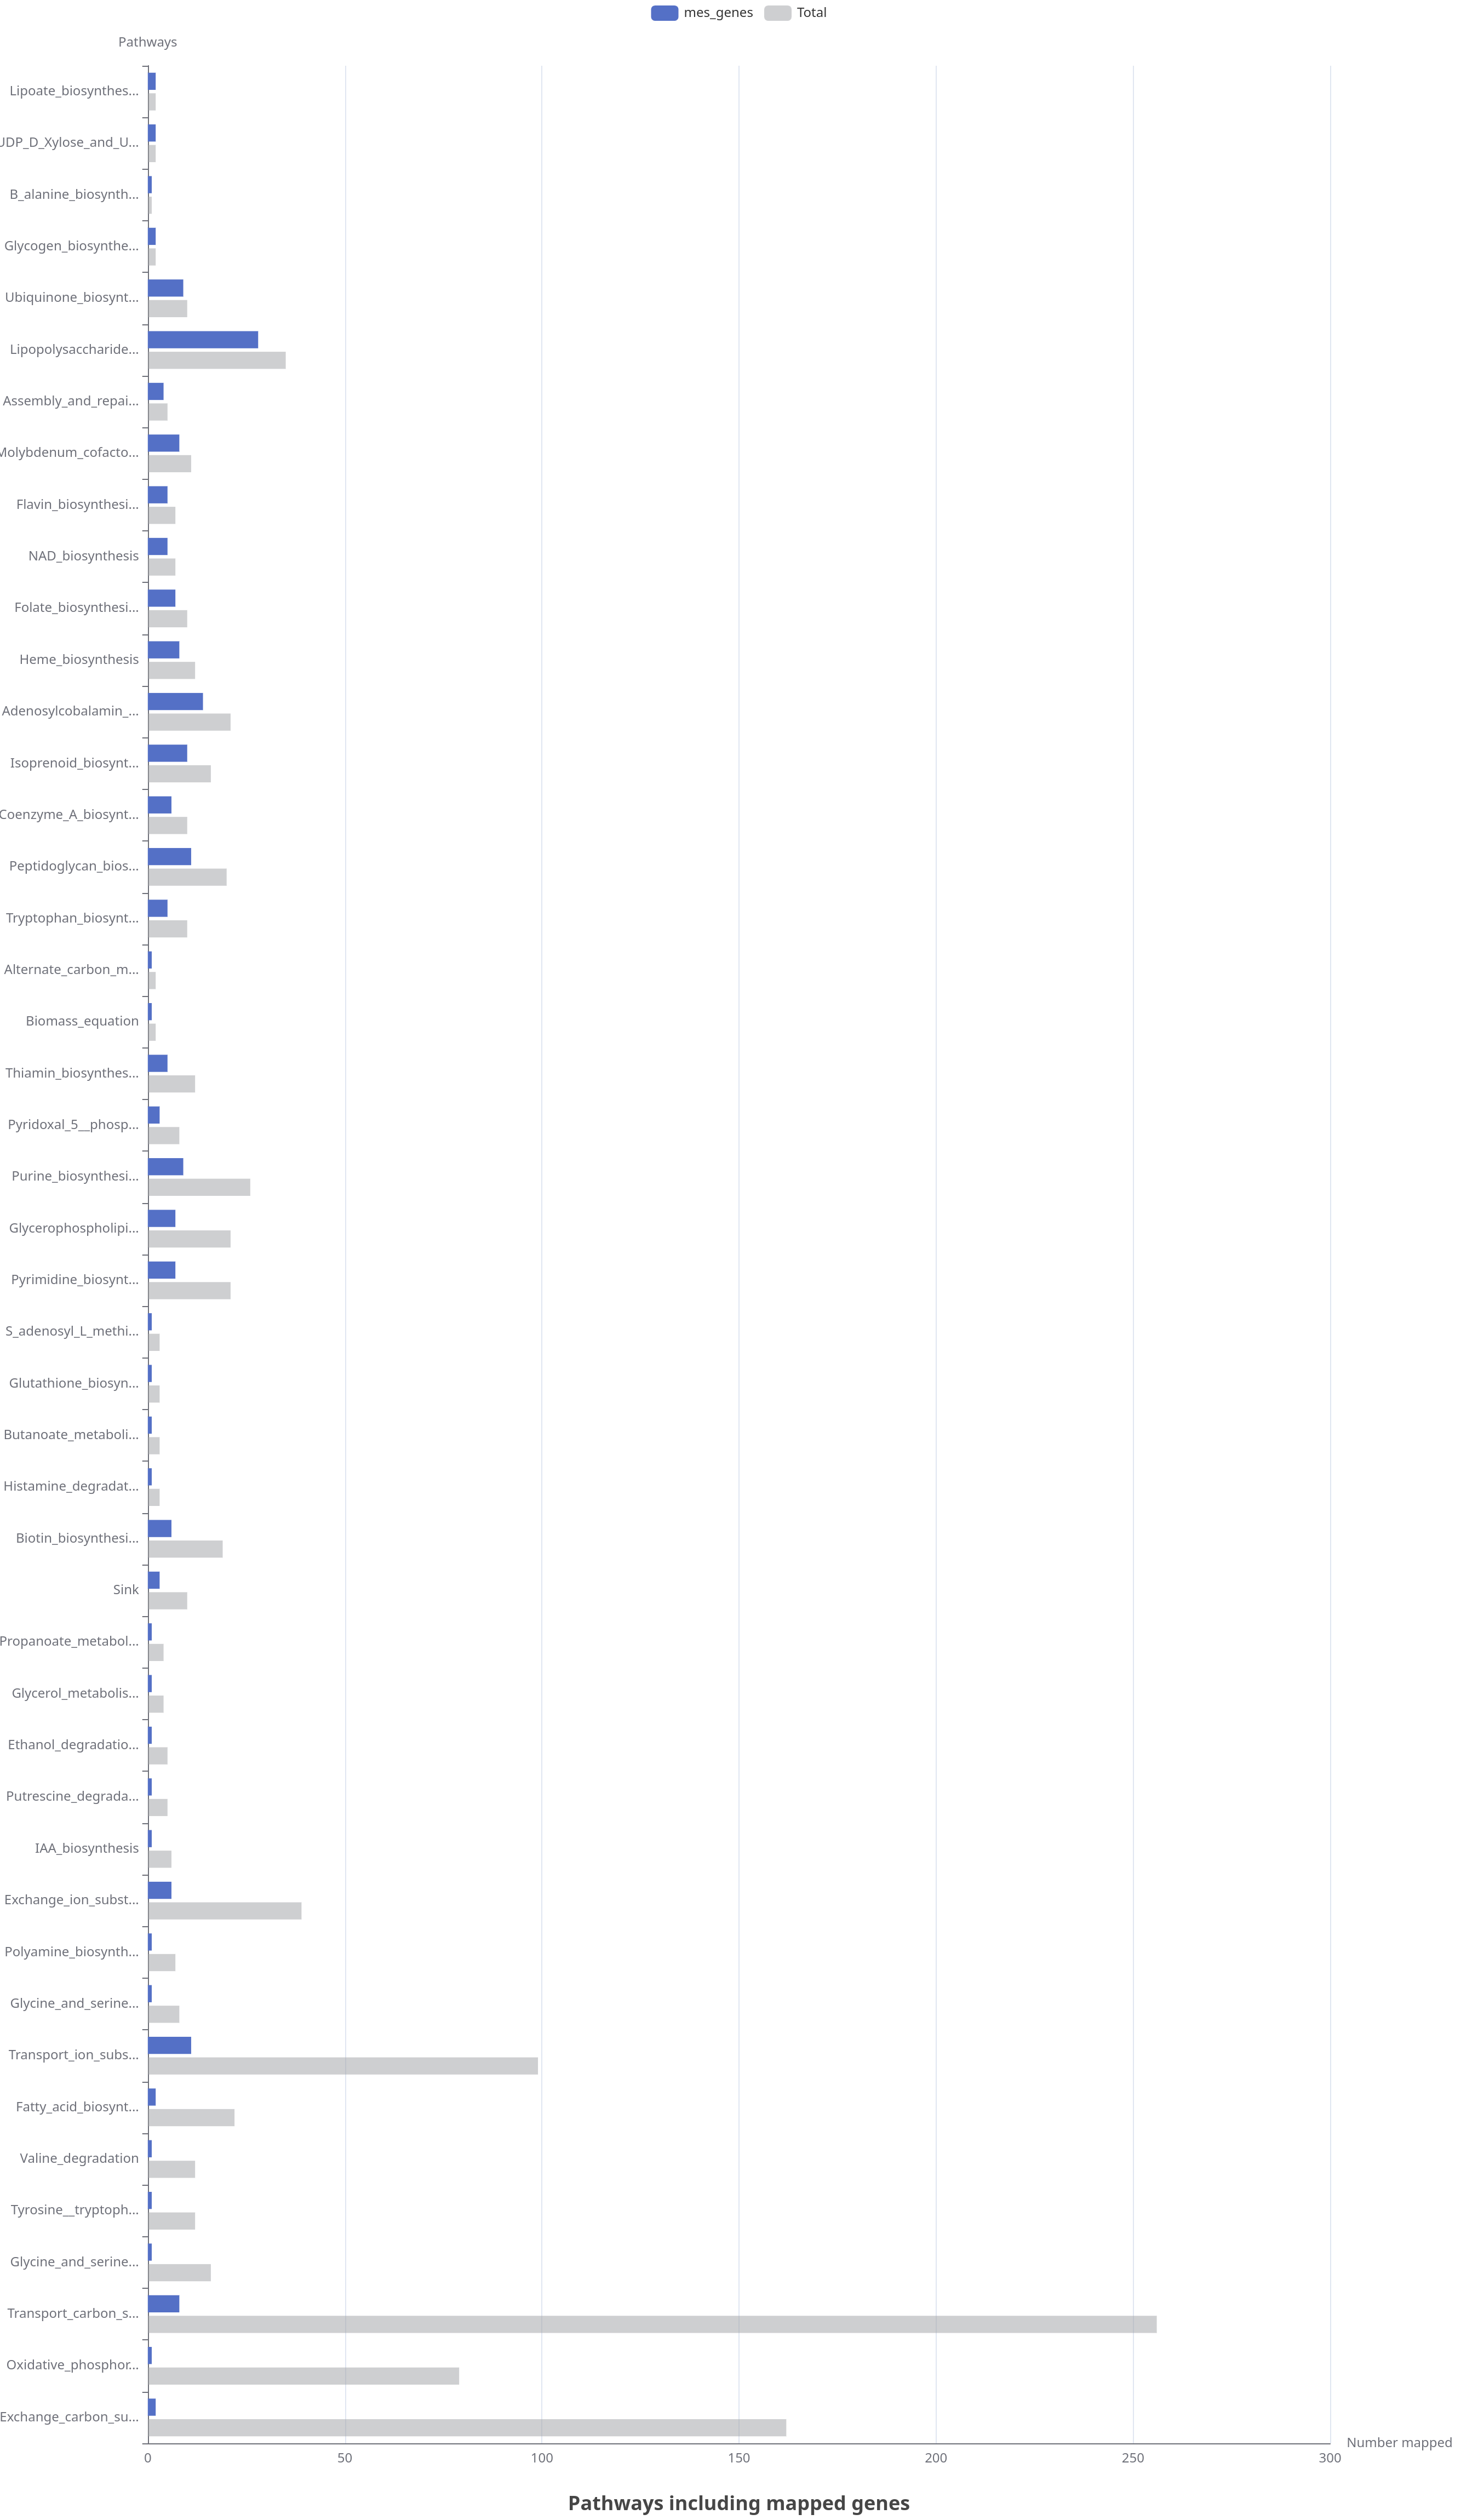